## Imports

In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gluonts.dataset.multivariate_grouper import MultivariateGrouper
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.split import split
from huggingface_hub import hf_hub_download

from uni2ts.eval_util.plot import plot_single
from uni2ts.model.moirai import MoiraiForecast, MoiraiModule
from uni2ts.model.moirai_moe import MoiraiMoEForecast, MoiraiMoEModule

from ctf4science.data_module import load_validation_dataset, load_dataset, get_prediction_timesteps, get_validation_prediction_timesteps, get_validation_training_timesteps, get_metadata

/mmfs1/home/alexeyy/storage/CTF-for-Science/models/moirai/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Model Parameters

In [2]:
MODEL = "moirai-moe"  # model name: choose from {'moirai', 'moirai-moe'}
SIZE = "small"  # model size: choose from {'small', 'base', 'large'}
#PDT = 20  # prediction length: any positive integer
#CTX = 200  # context length: any positive integer
PSZ = "auto"  # patch size: choose from {"auto", 8, 16, 32, 64, 128}
BSZ = 32  # batch size: any positive integer
#TEST = 100  # test set length: any positive integer

## Data

In [3]:
# Pair ids 2, 4: reconstruction
# Pair ids 1, 3, 5-7: forecast
# Pair ids 8, 9: burn-in
pair_id = 1
dataset = 'ODE_Lorenz'
validation = True
recon_ctx = 100 # Context length for reconstruction

md = get_metadata(dataset)

if validation:
    train_data, val_data, init_data = load_validation_dataset(dataset, pair_id=pair_id)
    forecast_length = get_validation_prediction_timesteps(dataset, pair_id).shape[0]
else:
    train_data, init_data = load_dataset(dataset, pair_id=pair_id)
    forecast_length = get_prediction_timesteps(dataset, pair_id).shape[0]

print(f"Predicting {dataset} for pair {pair_id} with forecast length {forecast_length}")

delta_t = md['delta_t']

# Perform pair_id specific operations
if pair_id in [2, 4]:
    # Reconstruction
    train_mat = train_data[0]
    train_mat = train_mat[0:recon_ctx,:]
    forecast_length = forecast_length - recon_ctx
    df = pd.DataFrame(train_mat)
elif pair_id in [1, 3, 5, 6, 7]:
    # Forecast
    train_mat = train_data[0]
    df = pd.DataFrame(train_mat)
elif pair_id in [8, 9]:
    # Burn-in
    train_mat = init_data
    df = pd.DataFrame(train_mat)
else:
    raise ValueError(f"Pair id {pair_id} not supported")

# Model variables
PDT = forecast_length
CTX = df.shape[0]
TEST = PDT

PDT = 100
CTX = 20
TEST = PDT

# Append TEST (forecast_length) of zeros to each column of the dataset
print("df shape before:", df.shape)
df = pd.concat([df, pd.DataFrame(2.*np.ones((TEST, df.shape[1])), columns=df.columns)], axis=0)
print("df shape after:", df.shape)

# Create DateTimeIndex starting from 0 seconds with delta_t intervals
start_time = pd.Timestamp('2020-01-01')  
timestamps = pd.date_range(start=start_time, 
                            periods=len(df),
                            freq=f'{delta_t}S')
df.index = timestamps

# Convert into GluonTS dataset with frequency in seconds
ds = PandasDataset(dict(df), freq=f'{delta_t}S')

print("PDT:", PDT)
print("CTX:", CTX)
print("TEST:", TEST)

print("Data head:")
display(df.head())
print("Data tail:")
display(df.tail())


Predicting ODE_Lorenz for pair 1 with forecast length 2000
df shape before: (8000, 3)
df shape after: (8100, 3)
PDT: 100
CTX: 20
TEST: 100
Data head:


,0,1,2
2020-01-01 00:00:00.000,3.605978,-12.255331,11.353701
2020-01-01 00:00:00.050,-2.272271,-11.366254,9.743825
2020-01-01 00:00:00.100,-6.466494,-14.764910,11.252892
2020-01-01 00:00:00.150,-10.886550,-20.256239,17.065432
2020-01-01 00:00:00.200,-15.380908,-23.034288,28.771323


Data tail:


,0,1,2
2020-01-01 00:06:44.750,2.0,2.0,2.0
2020-01-01 00:06:44.800,2.0,2.0,2.0
2020-01-01 00:06:44.850,2.0,2.0,2.0
2020-01-01 00:06:44.900,2.0,2.0,2.0
2020-01-01 00:06:44.950,2.0,2.0,2.0


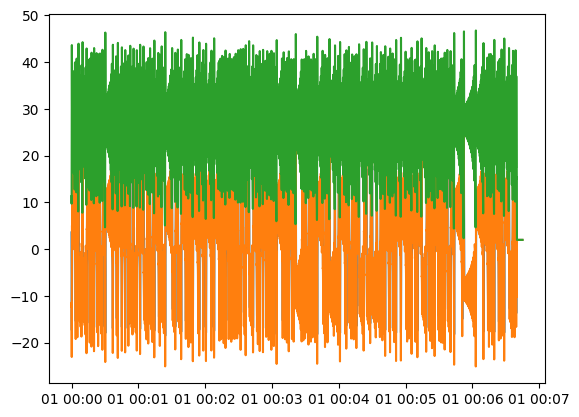

In [4]:

plt.plot(df)


## Run Model

In [5]:
# Group time series into multivariate dataset
grouper = MultivariateGrouper(len(ds))
multivar_ds = grouper(ds)

# Split into train/test set
train, test_template = split(
    multivar_ds, offset=-TEST
)  # assign last TEST time steps as test set

# Construct rolling window evaluation
test_data = test_template.generate_instances(
    prediction_length=PDT,  # number of time steps for each prediction
    windows=TEST // PDT,  # number of windows in rolling window evaluation
    distance=PDT,  # number of time steps between each window - distance=PDT for non-overlapping windows
)

# Prepare model
if MODEL == "moirai":
    model = MoiraiForecast(
        module=MoiraiModule.from_pretrained(f"Salesforce/moirai-1.1-R-small"),
        prediction_length=PDT,
        context_length=CTX,
        patch_size=PSZ,
        num_samples=100,
        target_dim=len(ds),
        feat_dynamic_real_dim=ds.num_feat_dynamic_real,
        past_feat_dynamic_real_dim=ds.num_past_feat_dynamic_real,
    )
elif MODEL == "moirai-moe":
    model = MoiraiMoEForecast(
        module=MoiraiMoEModule.from_pretrained(f"Salesforce/moirai-moe-1.0-R-small"),
        prediction_length=PDT,
        context_length=CTX,
        patch_size=16,
        num_samples=100,
        target_dim=len(ds),
        feat_dynamic_real_dim=ds.num_feat_dynamic_real,
        past_feat_dynamic_real_dim=ds.num_past_feat_dynamic_real,
    )

predictor = model.create_predictor(batch_size=BSZ, device='auto')
forecasts = predictor.predict(test_data.input)

input_it = iter(test_data.input)
label_it = iter(test_data.label)
forecast_it = iter(forecasts)

# Make predictions
inp = next(input_it)
label = next(label_it)
forecast = next(forecast_it)

## Create Prediction Matrix

In [6]:

target = np.concatenate([inp["target"], label["target"]], axis=-1) 
start = inp["start"]

raw_pred = forecast.quantile(0.5)

print("Prediction shape:", raw_pred.shape)
print("Train shape:", train_mat.shape)

# Perform pair_id specific operations
if pair_id in [2, 4]:
    # Reconstruction
    pred = np.vstack([train_mat, raw_pred])
    print("ding!")
elif pair_id in [1, 3, 5, 6, 7]:
    # Forecast
    #pred = np.vstack([train_mat, raw_pred])
    pred = raw_pred
elif pair_id in [8, 9]:
    # Burn-in
    pred = np.vstack([train_mat, raw_pred])
else:
    raise ValueError(f"Pair id {pair_id} not supported") 

print("Final shape:", pred.shape)


Prediction shape: (100, 3)
Train shape: (8000, 3)
Final shape: (100, 3)


## Plot

val shape: (2000, 3)
pred shape: (100, 3)


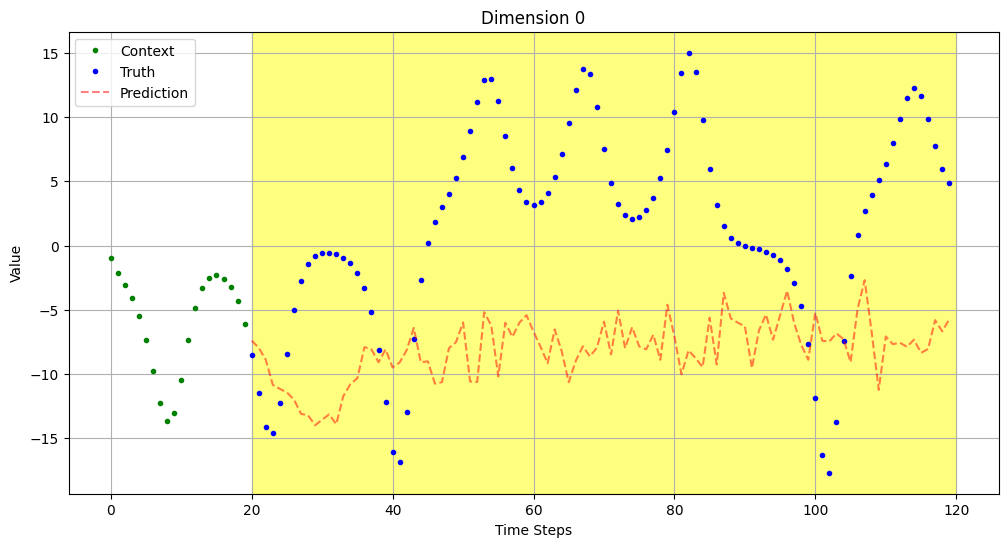

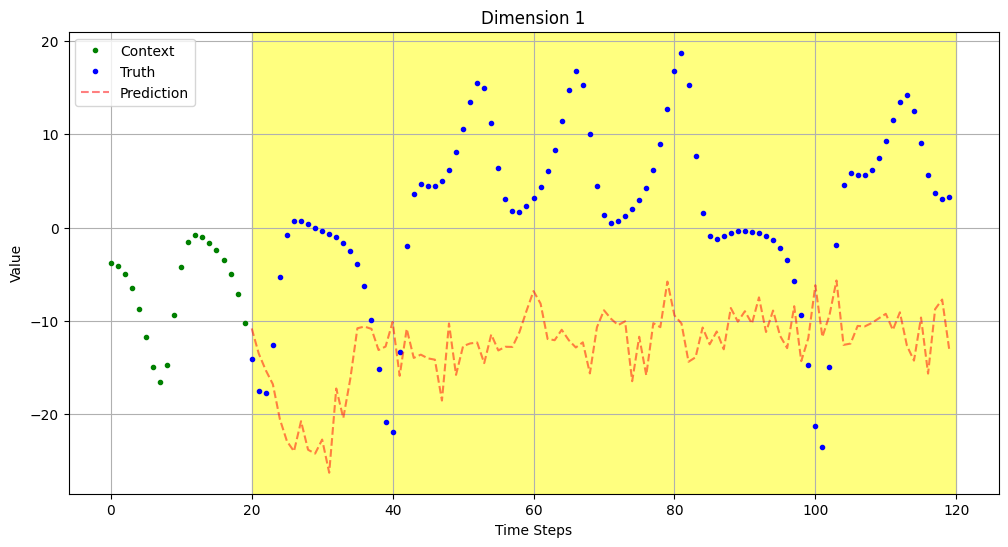

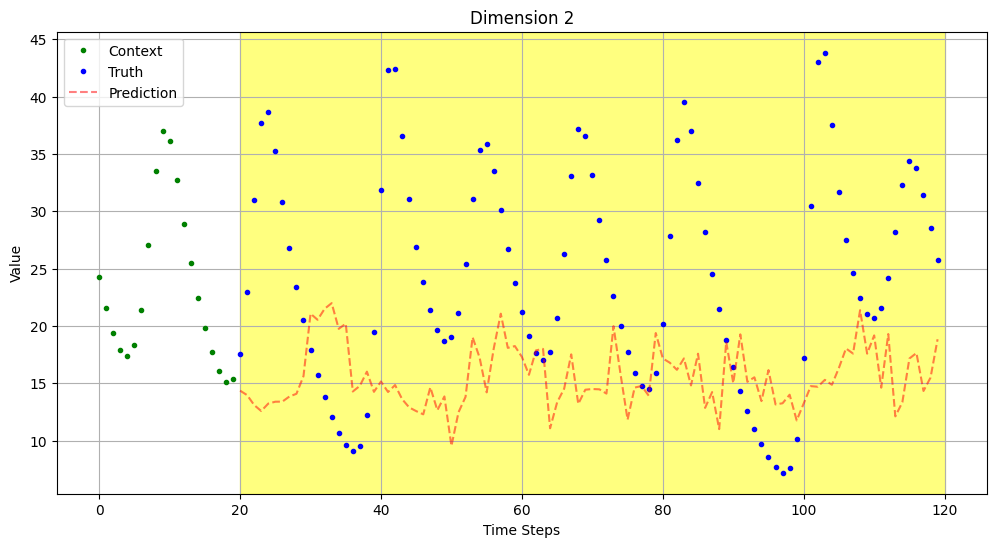

In [9]:
print("val shape:", val_data.shape)
print("pred shape:", pred.shape)

for i in range(df.shape[1]):
    # Plot the context and then the truth and prediction
    plt.figure(figsize=(12,6))

    if pair_id not in [2, 4, 8, 9]:
        # Plot N points of context
        N = 20
        plt.plot(train_mat[-N:,i], 'g.', label='Context')
        x_v = np.arange(N, N+pred.shape[0])
    else:
        x_v = np.arange(0, pred.shape[0])

    # Plot truth
    plt.plot(x_v, val_data[:pred.shape[0],i], 'b.', label='Truth')
   
    # Plot truth points
    plt.plot(x_v, pred[:,i], 'r--', label='Prediction', alpha=0.5)

    # Highlight last PDT region as yellow
    plt.axvspan(pred.shape[0] - PDT + x_v[0], pred.shape[0] + x_v[0], color='yellow', alpha=0.5)

    plt.title(f'Dimension {i}')
    plt.xlabel('Time Steps')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()

    print()


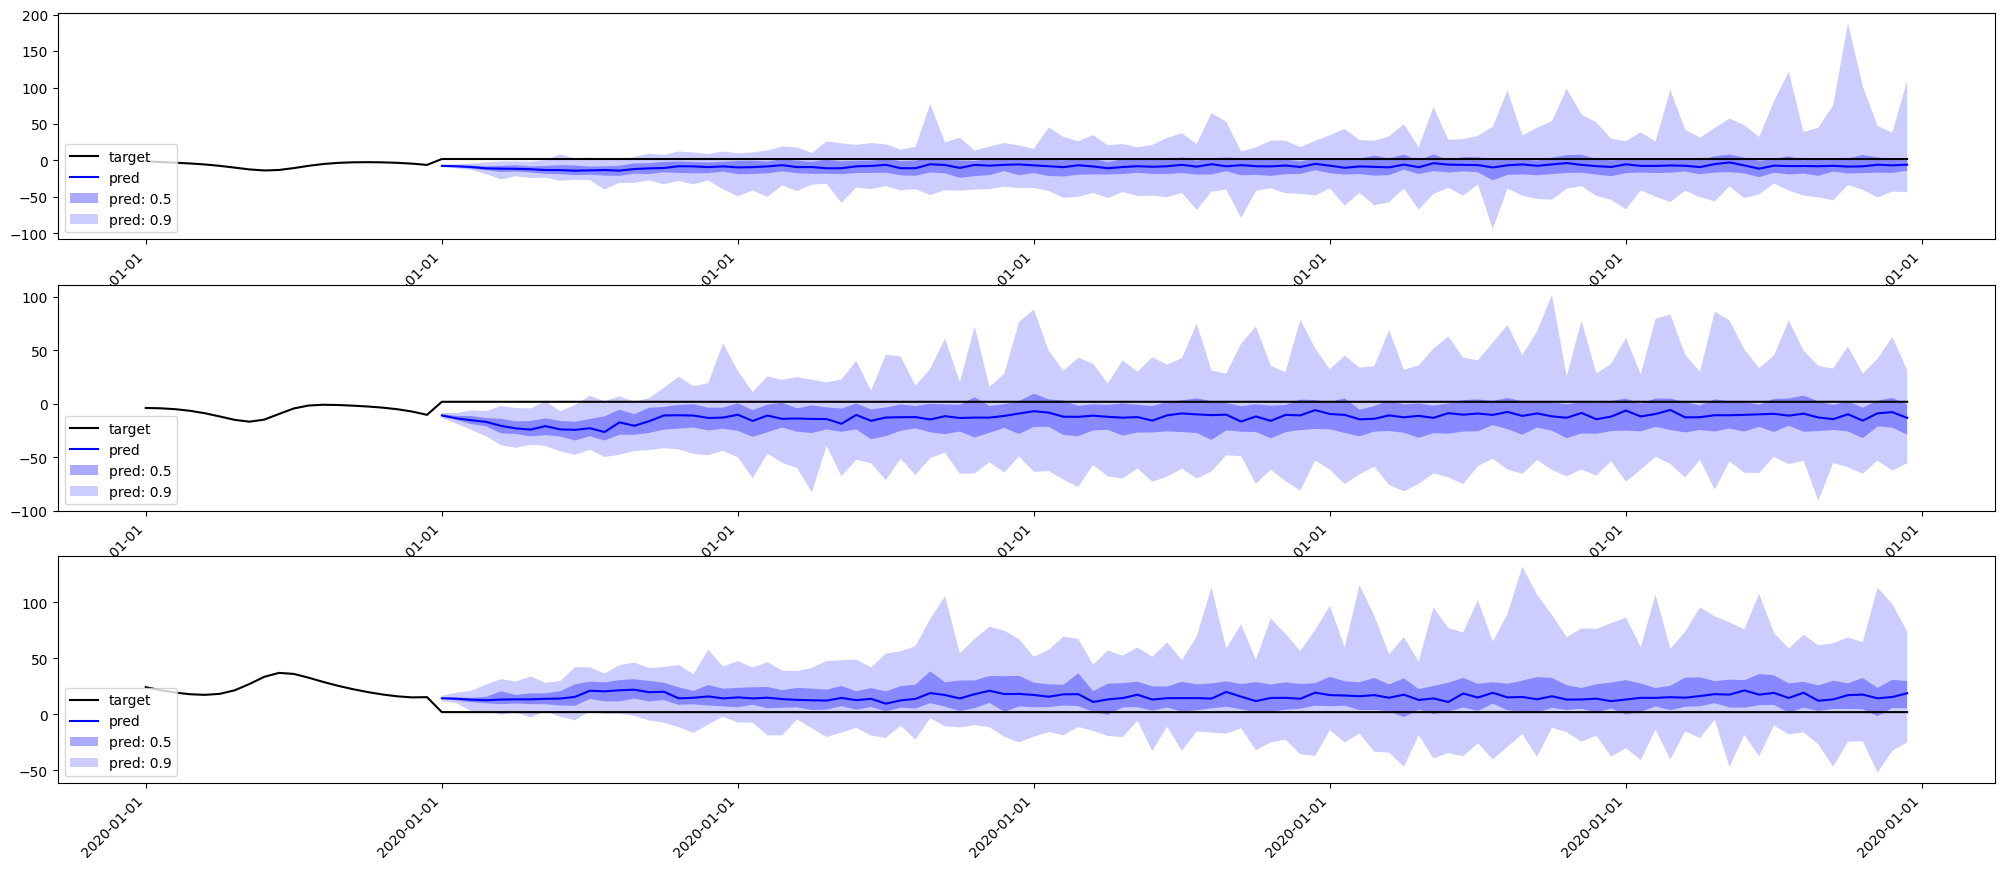

In [8]:

# Visualize different dimensions
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(25, 10))
for i, ax in enumerate(axes.flatten()):
    plot_single(
        inp,
        label,
        forecast,
        context_length=CTX,
        intervals=(0.5, 0.9),
        dim=i,
        ax=ax,
        name="pred",
        show_label=True,
    )